In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.special import softmax
from tqdm import tqdm 
from collections import Counter
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
warnings.simplefilter("always", ConvergenceWarning)

In [2]:
from maml.datasets.miniimagenet import MiniimagenetMetaDataset
from maml.models.gated_conv_net_original import ImpRegConvModel
from maml.models.conv_embedding_model import RegConvEmbeddingModel
from maml.logistic_regression_utils import logistic_regression_grad_with_respect_to_w, logistic_regression_hessian_pieces_with_respect_to_w, logistic_regression_hessian_with_respect_to_w, logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X
from maml.logistic_regression_utils import logistic_regression_mixed_derivatives_with_respect_to_w_then_to_X_left_multiply
from maml.algorithm import MetaOptnet, ProtoNet, ImpRMAML_inner_algorithm

In [3]:
def sample_indices(array, n_classes):
    for c in range(n_classes):
        np.argwhere(array==c)
def compute_variance(estimators, n_classes):
    estimators = torch.cat(estimators, dim=0).numpy()
    assert estimators.shape[1] == n_classes
    assert len(estimators.shape) == 3
    _explained_variance_ratio = []
    for i in range(n_classes):
        est = estimators[:, i, :]
        est = est - est.mean(0)
        svd = TruncatedSVD(n_components=min(est.shape), n_iter=10, random_state=42)
        S = svd.fit(est.T @ est)
#         print(f"class: {i+1} exp. variance: ", S.explained_variance_ratio_)
#         print(f"class: {i+1} svd values : ", S.singular_values_)
        _explained_variance_ratio.append(S.explained_variance_ratio_)
    return np.stack(_explained_variance_ratio, axis=0)

In [4]:
variance_stat = {}

# SVM 5w5s

MiniImagenet val
add_bias to output features :  False


  0%|          | 0/120 [00:00<?, ?it/s]

Before Modulation
tensor([17.7936, 15.9337, 17.9058, 16.8586, 16.6797, 15.8675, 17.2483, 16.4833,
        16.4663, 15.0004, 16.8906, 18.0275, 16.0311, 17.0132, 17.0913, 17.4745,
        17.3989, 17.4011, 17.1517, 16.9257, 17.6283, 16.0403, 17.2479, 16.6842,
        17.1293], device='cuda:1', grad_fn=<NormBackward1>)


100%|██████████| 120/120 [00:13<00:00,  8.80it/s]


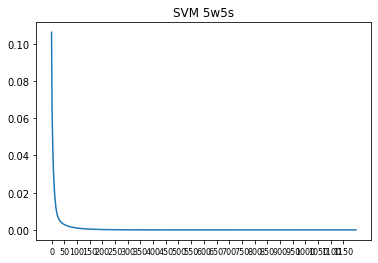

In [5]:
exp_name = 'SVM 5w5s'
chkpt = './inner_solvers/minim_5w5s_SVM/maml_impregconv_20000.pt'
torch.cuda.set_device(1)
n_runs = 10
n_way=5
n_shot=5

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=64,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = MetaOptnet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            estimators.append(algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).detach().cpu())
    explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))

variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)
plt.plot(variance_stat[exp_name])
plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
plt.title(exp_name)
plt.show()

# SVM 5w1s

In [ ]:
exp_name = 'SVM 5w1s'
chkpt = './inner_solvers/minim_5w1s_SVM/maml_impregconv_22000.pt'
torch.cuda.set_device(1)
n_runs = 2
n_way=5
n_shot=1

# dataset
dataset = MiniimagenetMetaDataset(
    root='data',
    img_side_len=84,
    num_classes_per_batch=n_way,
    num_samples_per_class=600, # num train samples per class
    num_total_batches=10,
    num_val_samples=0, # num test samples per class
    meta_batch_size=1,
    split='val', # meta train/val/test
    num_workers=4,
    device='cuda')
num_channels = 64


# model 
model = ImpRegConvModel(
        input_channels=dataset.input_size[0],
        output_size=dataset.output_size,
        num_channels=64,
        img_side_len=dataset.input_size[1],
        use_max_pool=False, # currently not used
        verbose=False,
        use_group_norm=True,
        retain_activation=True,
        add_bias=False)
state_dict = torch.load(chkpt)
model.load_state_dict(state_dict['model'])
model.to('cuda')


# algorithm
algorithm = MetaOptnet(
    model=model,
    inner_loss_func=torch.nn.CrossEntropyLoss(),
    n_way=n_way,
    n_shot_train=n_shot,
    n_shot_val=n_shot,
    device='cuda')


# start variance computation
explained_variance_ratio = []
for train_task_batch, _ in iter(dataset):

    train_task = train_task_batch[0]
    n_samples = train_task.x.shape[0]
    train_task_batch_x = torch.stack([task.x for task in train_task_batch], dim=0)
    train_task_batch_y = torch.stack([task.y for task in train_task_batch], dim=0)
    n_samples_per_class = n_samples // n_way
    n_tasks = (n_samples_per_class // n_shot)
    estimators = []
        
    for _ in range(n_runs):
        train_task_batch_x_shuffled = []
        for i in range(n_way):
            random_indices = np.random.permutation(n_samples_per_class)
            train_task_batch_x_shuffled.append(train_task_batch_x[:, random_indices + i*n_samples_per_class])
        train_task_batch_x = torch.cat(train_task_batch_x_shuffled, dim=1)
        for i in tqdm(range(0, n_tasks)):
            indices = np.array(
                [[n_samples_per_class*j + n_shot*i + k for k in range(n_shot)] for j in range(n_way)]
            ).reshape(-1).tolist()
            samples_x = train_task_batch_x[:,indices]
            samples_y = train_task_batch_y[:,indices]
            assert len(set(samples_y.view(-1).cpu().numpy())) == n_way
        #         print(samples_x.shape, samples_y.shape, len(set(samples_y.view(-1))))
            estimators.append(algorithm.inner_loop_adapt(
                support=samples_x, 
                support_labels=samples_y, 
                query=samples_x,
                return_estimator=True
            ).detach().cpu())
    explained_variance_ratio.append(compute_variance(estimators, n_classes=n_way))

variance_stat[exp_name] = np.concatenate(explained_variance_ratio, axis=0).mean(0)
plt.plot(variance_stat[exp_name])
plt.xticks(np.arange(0, variance_stat[exp_name].shape[-1], 50), size=8)
plt.title(exp_name)
plt.show()

MiniImagenet val
add_bias to output features :  False


  0%|          | 1/600 [00:00<01:15,  7.90it/s]

Before Modulation
tensor([17.0096, 15.3125, 17.6652, 16.3355, 16.0569], device='cuda:1',
       grad_fn=<NormBackward1>)


 77%|███████▋  | 462/600 [00:29<00:08, 17.03it/s]


--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------



100%|██████████| 600/600 [00:38<00:00, 15.54it/s]
